In [1]:
import sys, importlib
sys.path.append('../')

from Modules.Utils.Imports import *

from Modules.Models.BuildSurfaceFitter import BuildSurfaceFitter
from Modules.Utils.Gradient import Gradient
from Modules.Utils.ModelWrapper import ModelWrapper

In [2]:
device = torch.device(GetLowestGPU(pick_from=[]))

Device set to cpu


# Save surface data and plot residuals

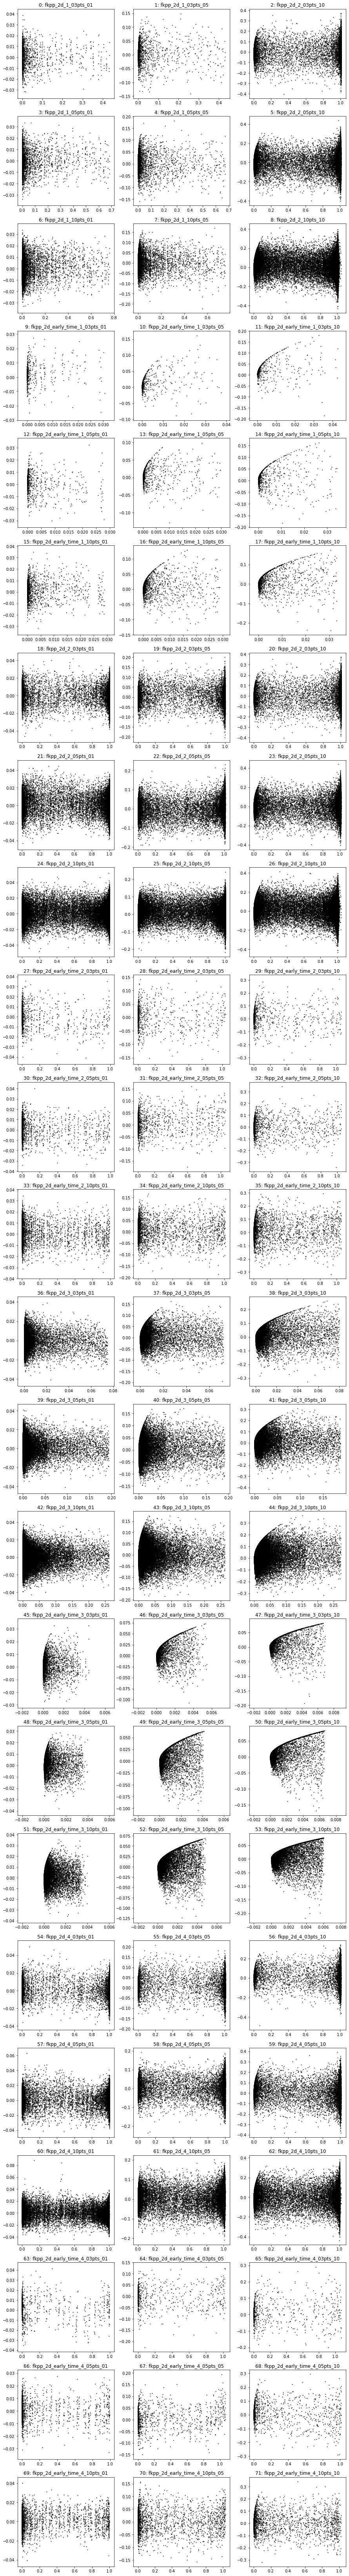

In [3]:
plot = True
save = False

# 2D Fisher KPP
path = '../../Data/Surfaces/FKPP2D/'
files = [
    'fkpp_2d_1_03pts_01.npy','fkpp_2d_1_03pts_05.npy','fkpp_2d_2_03pts_10.npy',
    'fkpp_2d_1_05pts_01.npy','fkpp_2d_1_05pts_05.npy','fkpp_2d_2_05pts_10.npy',
    'fkpp_2d_1_10pts_01.npy','fkpp_2d_1_10pts_05.npy','fkpp_2d_2_10pts_10.npy',
    'fkpp_2d_early_time_1_03pts_01.npy','fkpp_2d_early_time_1_03pts_05.npy','fkpp_2d_early_time_1_03pts_10.npy',
    'fkpp_2d_early_time_1_05pts_01.npy','fkpp_2d_early_time_1_05pts_05.npy','fkpp_2d_early_time_1_05pts_10.npy',
    'fkpp_2d_early_time_1_10pts_01.npy','fkpp_2d_early_time_1_10pts_05.npy','fkpp_2d_early_time_1_10pts_10.npy',
    'fkpp_2d_2_03pts_01.npy','fkpp_2d_2_03pts_05.npy','fkpp_2d_2_03pts_10.npy',
    'fkpp_2d_2_05pts_01.npy','fkpp_2d_2_05pts_05.npy','fkpp_2d_2_05pts_10.npy',
    'fkpp_2d_2_10pts_01.npy','fkpp_2d_2_10pts_05.npy','fkpp_2d_2_10pts_10.npy',
    'fkpp_2d_early_time_2_03pts_01.npy','fkpp_2d_early_time_2_03pts_05.npy','fkpp_2d_early_time_2_03pts_10.npy',
    'fkpp_2d_early_time_2_05pts_01.npy','fkpp_2d_early_time_2_05pts_05.npy','fkpp_2d_early_time_2_05pts_10.npy',
    'fkpp_2d_early_time_2_10pts_01.npy','fkpp_2d_early_time_2_10pts_05.npy','fkpp_2d_early_time_2_10pts_10.npy',
    'fkpp_2d_3_03pts_01.npy','fkpp_2d_3_03pts_05.npy','fkpp_2d_3_03pts_10.npy',
    'fkpp_2d_3_05pts_01.npy','fkpp_2d_3_05pts_05.npy','fkpp_2d_3_05pts_10.npy',
    'fkpp_2d_3_10pts_01.npy','fkpp_2d_3_10pts_05.npy','fkpp_2d_3_10pts_10.npy',
    'fkpp_2d_early_time_3_03pts_01.npy','fkpp_2d_early_time_3_03pts_05.npy','fkpp_2d_early_time_3_03pts_10.npy',
    'fkpp_2d_early_time_3_05pts_01.npy','fkpp_2d_early_time_3_05pts_05.npy','fkpp_2d_early_time_3_05pts_10.npy',
    'fkpp_2d_early_time_3_10pts_01.npy','fkpp_2d_early_time_3_10pts_05.npy','fkpp_2d_early_time_3_10pts_10.npy',
    'fkpp_2d_4_03pts_01.npy','fkpp_2d_4_03pts_05.npy','fkpp_2d_4_03pts_10.npy',
    'fkpp_2d_4_05pts_01.npy','fkpp_2d_4_05pts_05.npy','fkpp_2d_4_05pts_10.npy',
    'fkpp_2d_4_10pts_01.npy','fkpp_2d_4_10pts_05.npy','fkpp_2d_4_10pts_10.npy',
    'fkpp_2d_early_time_4_03pts_01.npy','fkpp_2d_early_time_4_03pts_05.npy','fkpp_2d_early_time_4_03pts_10.npy',
    'fkpp_2d_early_time_4_05pts_01.npy','fkpp_2d_early_time_4_05pts_05.npy','fkpp_2d_early_time_4_05pts_10.npy',
    'fkpp_2d_early_time_4_10pts_01.npy','fkpp_2d_early_time_4_10pts_05.npy','fkpp_2d_early_time_4_10pts_10.npy']

# build surface fitter
surface_fitter = BuildSurfaceFitter(
    input_variables=3, 
    hidden_layers=[256, 256, 256], 
    output_variables=1, 
    activations=[nn.Sigmoid()],
    output_activation=nn.Softplus()) 
surface_fitter = surface_fitter.to(device)
surface_fitter = surface_fitter.to(device)
model = ModelWrapper(
    surface_fitter,
    optimizer=None,
    loss=None,
    save_opt=False)

# data normalizer
def normalize(x):
    x_min = np.min(x)
    x -= x_min
    x_max = np.max(x)
    x /= x_max
    return x, x_min, x_max

# keep a count to see if anything needs retraining
count = 0

# loop over each surface
fig = plt.figure(figsize=(5*3,5*int(np.ceil(len(files)/3))))
for file_index in range(len(files)):
    
    # only do one data set
    #if count != 24:
    #    count += 1
    #    continue
    
    # only do a range of data sets
    #start, stop = 0, 5
    #if count < start or count > stop:
    #    count += 1
    #    continue
    
    # load data
    file_name = files[file_index]
    file = np.load(path + file_name, allow_pickle=True, encoding='latin1').item()
    inputs = file['inputs']
    shapes = file['shape']
    outputs = file['outputs']
    gamma = file['gamma']
    
    # normalize
    x = inputs[:, 0].astype(np.float)
    x, x_min, x_max = normalize(x)
    y = inputs[:, 1].astype(np.float)
    y, y_min, y_max = normalize(y)
    t = inputs[:, 2].astype(np.float)
    t, t_min, t_max = normalize(t)
    u = outputs[:, 0].astype(np.float)
    
    # convert to input and output matrices
    inputs = np.concatenate([x[:, None], 
                             y[:, None], 
                             t[:, None]], axis=1)
    outputs = u[:, np.newaxis]
    
    # convert to torch
    def numpy_to_tensor(ndarray):
        arr = torch.tensor(ndarray, dtype=torch.float)
        arr.requires_grad_(True)
        arr = arr.to(device)
        return arr
    inputs = numpy_to_tensor(inputs)
    outputs = numpy_to_tensor(outputs)
    
    # load model weights
    model.save_name = '../Weights/'+path[-7:-1]+'/'+file_name[:-4]
    model.load_best_val(device=device)
    
    if plot:
        
        # model prediction
        U_pred = surface_fitter(inputs.to(device)).cpu().detach().numpy().reshape(-1)
        U_true = outputs.cpu().detach().numpy().reshape(-1)
        modified_residuals = (U_pred-U_true)/(np.abs(U_pred).clip(1e-10,1)**gamma)

        # plot modified residuals
        ax = fig.add_subplot(int(np.ceil(len(files)/3)), 3, count+1)
        plt.scatter(U_pred, modified_residuals, color='k', s=1)
        plt.title(str(count)+': '+file_name[:-4])
    
    if save:
        
        print(count)
        
        # predict
        outputs = surface_fitter(inputs)
        d1 = Gradient(outputs, inputs, order=1)
        d1 = [d1[:, i] for i in range(d1.shape[1])]
        d2 = [Gradient(d, inputs, order=1) for d in d1]
        d2 = [d2[i][:, j] for i in range(len(d1)) for j in range(len(d1))]

        # extract and rescale
        x = inputs[:, 0].cpu().detach().numpy() * x_max + x_min
        y = inputs[:, 1].cpu().detach().numpy() * y_max + y_min
        t = inputs[:, 2].cpu().detach().numpy() * t_max + t_min
        u_pred = outputs.cpu().detach().numpy()
        ux = d1[0].cpu().detach().numpy() / x_max
        uy = d1[1].cpu().detach().numpy() / y_max
        ut = d1[2].cpu().detach().numpy() / t_max
        uxx = d2[0].cpu().detach().numpy() / x_max / x_max
        uxy = d2[1].cpu().detach().numpy() / x_max / y_max
        uxt = d2[2].cpu().detach().numpy() / x_max / t_max
        uyx = d2[3].cpu().detach().numpy() / y_max / x_max
        uyy = d2[4].cpu().detach().numpy() / y_max / y_max
        uyt = d2[5].cpu().detach().numpy() / y_max / t_max
        utx = d2[6].cpu().detach().numpy() / t_max / x_max
        uty = d2[7].cpu().detach().numpy() / t_max / y_max
        utt = d2[8].cpu().detach().numpy() / t_max / t_max

        # store variables
        dictionary = {
            'variables': [x,y,t,u_pred,ux,uy,ut,uxx,uxy,uxt,uyx,uyy,uyt,utx,uty,utt],
            'variable_names': ['x','y','t','u','ux','uy','ut','uxx','uxy',
                               'uxt','uyx','uyy','uyt','utx','uty','utt'],
            'shapes': shapes,
            'gamma': gamma
        }
    
        np.save('../Results/2D/'+file_name[:-4]+'_ann', dictionary)
    
    count += 1
    
if plot:
    plt.show()

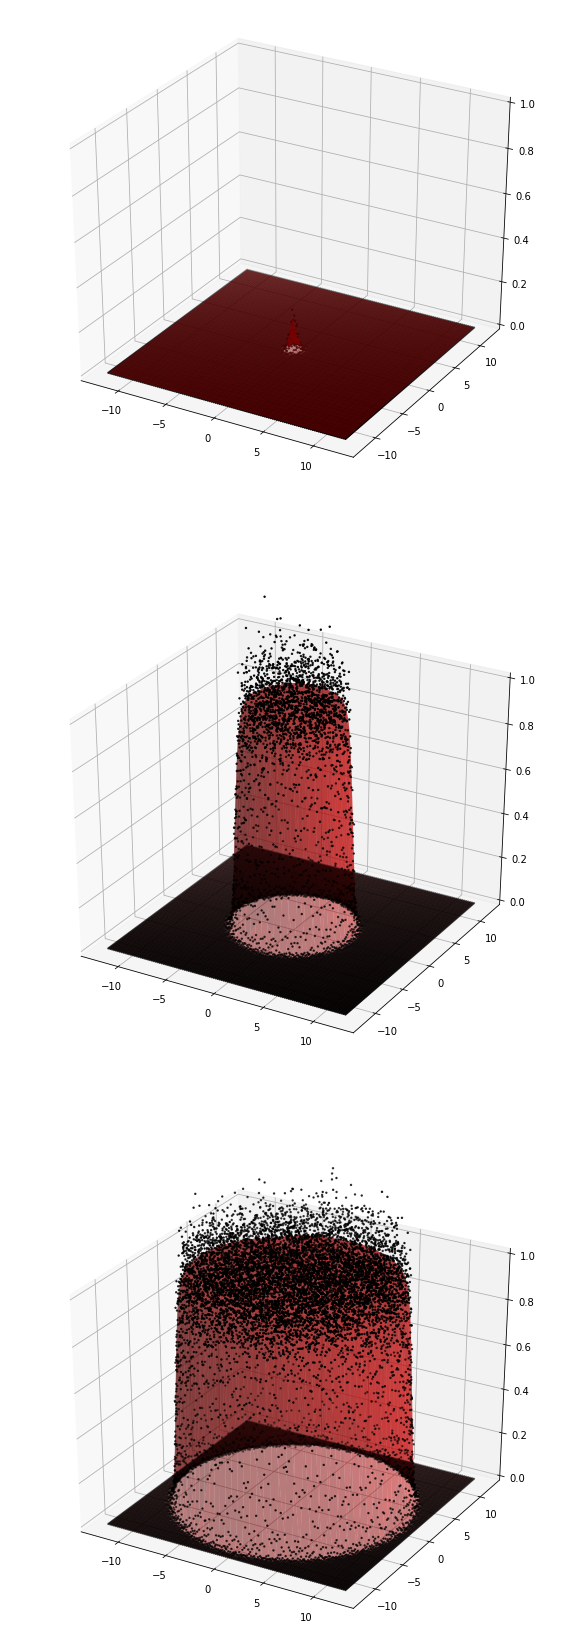

In [4]:
#
# plot individual surface fits
#

file_index = 2

# reload data
file_name = files[file_index]
file = np.load(path + file_name, allow_pickle=True, encoding='latin1').item()
inputs = file['inputs']
shapes = file['shape']
outputs = file['outputs']
gamma = file['gamma']
x = file['inputs'][:, 0].astype(np.float)
x, x_min, x_max = normalize(x)
y = file['inputs'][:, 1].astype(np.float)
y, y_min, y_max = normalize(y)
t = file['inputs'][:, 2].astype(np.float)
t, t_min, t_max = normalize(t)
u = file['outputs'][:, 0].astype(np.float)
inputs = np.concatenate([x[:, None], y[:, None], t[:, None]], axis=1)
outputs = u[:, None]
inputs = numpy_to_tensor(inputs)
outputs = numpy_to_tensor(outputs)

# reload model
model.save_name = '../Weights/'+path[-7:-1]+'/'+file_name[:-4]
model.load_best_val(device=device)

# predict
u_pred = surface_fitter(inputs).cpu().detach().numpy()

# extract and rescale
x = inputs[:, 0].cpu().detach().numpy() * x_max + x_min
y = inputs[:, 1].cpu().detach().numpy() * y_max + y_min
t = inputs[:, 2].cpu().detach().numpy() * t_max + t_min
u_true = outputs[:, 0].cpu().detach().numpy()

# convert to 2D
X, Y, T, U, U_true, U_pred = [], [], [], [], [], []
for i, shape in enumerate(shapes):
    
    # grab indices
    idx = np.where(t == np.unique(t)[i])
    
    # reshape into 2d slices
    X.append(x[idx].reshape(shape))
    Y.append(y[idx].reshape(shape))
    T.append(t[idx].reshape(shape))
    U_pred.append(u_pred[idx].reshape(shape))
    U_true.append(u_true[idx].reshape(shape))
    
# plot
def plot_surface(ax, X, Y, U_pred, U_true=None, umin=0, umax=1, skip=1):
    ax.plot_surface(X, Y, U_pred, color='r', alpha=0.5)
    if U_true is not None:
        #ax.plot_surface(X, Y, U_true, color='b', alpha=0.1)
        ax.scatter(X.reshape(-1)[::skip],
                   Y.reshape(-1)[::skip],
                   U_true.reshape(-1)[::skip],
                   s=2,c='k')
    #ax.set_xlim(-1, 1)
    #ax.set_ylim(-1, 1)
    ax.set_zlim(umin, umax)
    
if len(shapes)==3:
    fig = plt.figure(figsize=(10,30))
    for i in range(len(X)):
        ax = fig.add_subplot(3, 1, i+1, projection='3d')
        plot_surface(ax, X[i], Y[i], U_pred[i], U_true[i])
    plt.show()
    
if len(shapes)==5:
    fig = plt.figure(figsize=(14,3))
    for i in range(len(X)):
        ax = fig.add_subplot(1, 5, i+1, projection='3d')
        plot_surface(ax, X[i], Y[i], U_pred[i], U_true[i])
    plt.show()
    
if len(shapes)==10:
    fig = plt.figure(figsize=(15,35))
    for i in range(len(X)):
        ax = fig.add_subplot(5, 2, i+1, projection='3d')
        plot_surface(ax, 
                     X[i], 
                     Y[i], 
                     U_pred[i], 
                     U_true[i],
                     skip=5)
    plt.show()